In [6]:
# %% ============================== Setup ======================================
import os
import numpy as np
import pandas as pd

# Paths (as in the original script)
ATHLETES_CSV = "data/athletes.csv"
DAILY_CSV    = "data/daily_data.csv"
ACTIVITY_CSV = "data/activity_data.csv"

OUT_CSV = "bn_preprocessed.csv"

# Utility: find a "close" column name with fallback
def find_col(df, candidates, required=False):
    for c in candidates:
        if c in df.columns:
            return c
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    if required:
        raise KeyError(f"Could not find any of {candidates} in {list(df.columns)[:20]}...")
    return None

# Utility: rolling mean by group
def grouped_rolling_mean(s, group, window, min_periods=1):
    return s.groupby(group, group_keys=False).rolling(window, min_periods=min_periods).mean().reset_index(level=0, drop=True)

# Utility: Z-score by group
def zscore_by_group(s, group):
    # Add .replace(0, np.nan) to avoid infinite Z-scores if std is 0
    group_std = s.groupby(group).transform('std').replace(0, np.nan)
    group_mean = s.groupby(group).transform('mean')
    return (s - group_mean) / group_std

# Utility: Discretization
def discretize_qcut(series, q=3, labels=None):
    try:
        # 'duplicates="drop"' is crucial for data with many zeros (like rest days)
        return pd.qcut(series, q=q, labels=labels, duplicates="drop")
    except Exception:
        return pd.Series([np.nan]*len(series), index=series.index)

# %% ======================= Loading & Normalization ======================
print("Loading data...")
ath = pd.read_csv(ATHLETES_CSV)
day = pd.read_csv(DAILY_CSV)
act = pd.read_csv(ACTIVITY_CSV)

# Key names (let's try to infer them robustly)
ath_id_col = find_col(ath, ["athlete_id","id","user_id"], required=True)
day_id_col = find_col(day, ["athlete_id","id","user_id"], required=True)
act_id_col = find_col(act, ["athlete_id","id","user_id"], required=True)

# Standardize key ID name
ath = ath.rename(columns={ath_id_col:"athlete_id"})
day = day.rename(columns={day_id_col:"athlete_id"})
act = act.rename(columns={act_id_col:"athlete_id"})

# Type consistency
ath["athlete_id"] = ath["athlete_id"].astype(str)
day["athlete_id"] = day["athlete_id"].astype(str)
act["athlete_id"] = act["athlete_id"].astype(str)

# Dates
for df, name in [(day,"daily_data"), (act,"activity_data")]:
    date_col = find_col(df, ["date","day","activity_date","timestamp"])
    if date_col is None:
        raise KeyError(f"A date column (e.g., 'date') is required in {name}.")
    df["date"] = pd.to_datetime(df[date_col]).dt.tz_localize(None)


# %% ============ Baseline Variables (from athlete.csv) ==================
# Node 1: Training_Experience
# From your data: `training_experience`
exp_col = find_col(ath, ["training_experience", "training_age","years_of_practice"], required=True)
ath["Training_Experience"] = pd.to_numeric(ath[exp_col], errors="coerce") if exp_col else np.nan

# Node 2: Lifestyle_Factor (Derived)
# From your data: `nutrition_factor`, `stress_factor`, `smoking_factor`, `drinking_factor`
# --- CORRECTED LOGIC (BASED ON NUMERIC DATA) ---
# Create an aggregated score: +Nutrition -Stress -Smoking -Drinking
nutri_col = find_col(ath, ["nutrition_factor", "nutrition"])
stress_col_base = find_col(ath, ["stress_factor", "stress"])
smoke_col = find_col(ath, ["smoking_factor", "smoking"])
drink_col = find_col(ath, ["drinking_factor", "alcohol"])

# Calculate score only if columns exist
ath["_lifestyle_score"] = 0.0
if nutri_col:
    ath["_lifestyle_score"] += pd.to_numeric(ath[nutri_col], errors='coerce').fillna(0)
if stress_col_base:
    ath["_lifestyle_score"] -= pd.to_numeric(ath[stress_col_base], errors='coerce').fillna(0)
if smoke_col:
    ath["_lifestyle_score"] -= pd.to_numeric(ath[smoke_col], errors='coerce').fillna(0)
if drink_col:
    ath["_lifestyle_score"] -= pd.to_numeric(ath[drink_col], errors='coerce').fillna(0)

# %% ============ Feature Engineering (from activity_data) ===============
print("Aggregating activity data (for Avg_Intensity)...")

# Source for Node 8: Avg_Intensity
# From your data: `intensity_factor`
inten_col = find_col(act, ["intensity_factor","if"], required=True)
act["_intensity"] = pd.to_numeric(act[inten_col], errors="coerce")

# Aggregate by day/athlete
daily_agg = act.groupby(["athlete_id", "date"], as_index=False).agg(
    Avg_Intensity = ("_intensity", "mean") # Node 8
)

# %% ================== Merge & Daily Data ======================
print("Merging data...")
# Merge daily_data with aggregates from activity_data (for Avg_Intensity)
df = pd.merge(day, daily_agg, on=["athlete_id", "date"], how="outer")

# Add baseline data (from athlete.csv)
# --- KEY FIX ---
# Add suffixes to prevent column name collisions (e.g., 'sleep_quality_x')
df = pd.merge(df, ath, on="athlete_id", how="left", suffixes=("_day", "_ath"))

# Sort
df = df.sort_values(["athlete_id", "date"]).reset_index(drop=True)

# %% =================== Feature Engineering (Post-Merge) ===================
print("Calculating derived features...")

# Sources for Nodes 3, 4, 5, 7, 10 (from daily_data)
# From your data: `sleep_quality`, `hrv`, `stress`, `actual_tss`, `injury`
# --- CORRECTED COLUMN NAMES ---
sleep_q_col = find_col(df, ["sleep_quality_day", "sleep_quality","sleep_score"], required=True)
hrv_col = find_col(df, ["hrv", "hrv_ms","rmssd_ms","hrv_morning"], required=True)
stress_col_day = find_col(df, ["stress_day", "stress","stress_score"], required=True)
load_col = find_col(df, ["actual_tss", "tss"], required=True)
inj_col = find_col(df, ["injury","injured"], required=True)

df["Sleep_Quality"] = pd.to_numeric(df[sleep_q_col], errors="coerce")
df["Morning_HRV"]   = pd.to_numeric(df[hrv_col], errors="coerce")
df["Daily_Stress"]  = pd.to_numeric(df[stress_col_day], errors="coerce")
df["Training_Load"] = pd.to_numeric(df[load_col], errors="coerce")
df["Injury_Risk"]   = pd.to_numeric(df[inj_col], errors="coerce").fillna(0).clip(0,1).astype(int)

# Fill 0 for rest days (IMPORTANT: do this before rolling means)
df["Training_Load"] = df["Training_Load"].fillna(0.0)


# Node 9: Acute_Chronic_Ratio (Derived 3)
# Use `Training_Load` (Node 7) as input
df["_load_7d_mean"] = grouped_rolling_mean(df["Training_Load"], df["athlete_id"], 7)
df["_load_28d_mean"]= grouped_rolling_mean(df["Training_Load"], df["athlete_id"], 28)
df["Acute_Chronic_Ratio"] = df["_load_7d_mean"] / df["_load_28d_mean"]
df["Acute_Chronic_Ratio"] = df["Acute_Chronic_Ratio"].replace([np.inf, -np.inf], np.nan)

# Node 6: Ready_To_Train (Derived 2)
# Combination of (3) Sleep, (4) HRV, (5) Stress
# We use Z-scores normalized by athlete to make them comparable
z_sleep = zscore_by_group(df["Sleep_Quality"], df["athlete_id"])
z_hrv = zscore_by_group(df["Morning_HRV"], df["athlete_id"])
z_stress = zscore_by_group(df["Daily_Stress"], df["athlete_id"])
# Sum (positive Sleep and HRV, negative Stress)
df["_ready_score"] = z_sleep.fillna(0) + z_hrv.fillna(0) - z_stress.fillna(0)


# %% ======================== Discretization =============================
print("Discretizing variables...")
df_out = pd.DataFrame()
df_out["athlete_id"] = df["athlete_id"]
df_out["date"] = df["date"]

# --- Long-Term Factors ---
# 1. Training_Experience
df_out["Training_Experience"] = discretize_qcut(df["Training_Experience"], q=3, labels=["Low", "Medium", "High"])
# 2. Lifestyle_Factor (uses the new numeric _lifestyle_score)
df_out["Lifestyle_Factor"] = discretize_qcut(df["_lifestyle_score"], q=3, labels=["Negative", "Neutral", "Positive"])

# --- Recovery Indicators ---
# 3. Sleep_Quality
df_out["Sleep_Quality"] = discretize_qcut(df["Sleep_Quality"], q=3, labels=["Poor", "Good", "Great"])
# 4. Morning_HRV (using z-score for Low/Normal/High relative to the athlete)
df_out["Morning_HRV"] = discretize_qcut(z_hrv, q=3, labels=["Low", "Normal", "High"])
# 5. Daily_Stress
df_out["Daily_Stress"] = discretize_qcut(df["Daily_Stress"], q=3, labels=["Low", "Medium", "High"])
# 6. Ready_To_Train (2 states: Yes/No, based on the composite score)
df_out["Ready_To_Train"] = discretize_qcut(df["_ready_score"], q=2, labels=["No", "Yes"])

# --- Load and Demand ---
# 7. Training_Load (qcut will handle 0-load days by 'duplicates="drop"')
#   We replace 0 with NaN first so "Low" means "low training" not "rest"
df_out["Training_Load"] = discretize_qcut(df["Training_Load"].replace(0, np.nan), q=3, labels=["Low", "Medium", "High"])
# 8. Avg_Intensity
df_out["Avg_Intensity"] = discretize_qcut(df["Avg_Intensity"], q=3, labels=["Low", "Medium", "High"])

# 9. Acute_Chronic_Ratio
# As per your spec: Low (Good) vs Risk (High)
# We define "Risk" as being outside the "sweet spot" (e.g., 0.8-1.3)
df_out["Acute_Chronic_Ratio"] = "Low (Good)" # Default
df_out.loc[(df['Acute_Chronic_Ratio'] < 0.8) | (df['Acute_Chronic_Ratio'] > 1.3), 'Acute_Chronic_Ratio'] = 'Risk (High)'
df_out.loc[df['Acute_Chronic_Ratio'].isna(), 'Acute_Chronic_Ratio'] = np.nan # Propagate NaNs


# --- Outcome ---
# 10. Injury_Risk
df_out["Injury_Risk"] = df["Injury_Risk"].map({0: "No", 1: "Yes"})


# %% ==================== NaN Handling for BN =====================
# Discrete Bayesian networks do not handle NaNs.
# We convert NaNs to an explicit "Missing" category.

discrete_cols = [
    "Training_Experience", "Lifestyle_Factor", "Sleep_Quality", 
    "Morning_HRV", "Daily_Stress", "Ready_To_Train",
    "Training_Load", "Avg_Intensity", "Acute_Chronic_Ratio",
    "Injury_Risk"
]

print("Converting NaNs to 'Missing'...")
for col in discrete_cols:
    if col not in df_out.columns:
        print(f"Warning: Column {col} not found for fillna.")
        continue
    
    # Ensure the column is 'category' type
    if not pd.api.types.is_categorical_dtype(df_out[col]):
         df_out[col] = df_out[col].astype('category')
    
    # Add "Missing" as a category and fill NaNs
    if df_out[col].isnull().any():
        if "Missing" not in df_out[col].cat.categories:
            df_out[col] = df_out[col].cat.add_categories("Missing")
        df_out[col] = df_out[col].fillna("Missing")

# %% ============================== Export ====================================
cols_keep = [
    "athlete_id", "date",
    "Training_Experience", "Lifestyle_Factor", "Sleep_Quality",
    "Morning_HRV", "Daily_Stress", "Ready_To_Train",
    "Training_Load", "Avg_Intensity", "Acute_Chronic_Ratio",
    "Injury_Risk"
]

# Keep only the columns that actually exist
cols_keep_final = [c for c in cols_keep if c in df_out.columns]
df_final = df_out[cols_keep_final].copy()

df_final.to_csv(OUT_CSV, index=False)
print(f"\nSaved: {OUT_CSV} — rows: {len(df_final):,}")
print(f"Generated columns: {list(df_final.columns)}")
df_final.tail(5)

Loading data...
Aggregating activity data (for Avg_Intensity)...
Merging data...
Calculating derived features...
Discretizing variables...
Converting NaNs to 'Missing'...


/var/folders/c8/k22vp0k173j11cvw1ytbyp080000gn/T/ipykernel_6597/3009740546.py:224: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_out[col]):
/var/folders/c8/k22vp0k173j11cvw1ytbyp080000gn/T/ipykernel_6597/3009740546.py:224: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_out[col]):



Saved: bn_preprocessed.csv — rows: 366,000
Generated columns: ['athlete_id', 'date', 'Training_Experience', 'Lifestyle_Factor', 'Sleep_Quality', 'Morning_HRV', 'Daily_Stress', 'Ready_To_Train', 'Training_Load', 'Avg_Intensity', 'Acute_Chronic_Ratio', 'Injury_Risk']


,athlete_id,date,Training_Experience,Lifestyle_Factor,Sleep_Quality,Morning_HRV,Daily_Stress,Ready_To_Train,Training_Load,Avg_Intensity,Acute_Chronic_Ratio,Injury_Risk
365995,ffaec987-adb8-487b-a9e0-9ea1fa6ba582,2024-12-27,High,Neutral,Poor,Normal,High,No,Medium,Medium,Low (Good),No
365996,ffaec987-adb8-487b-a9e0-9ea1fa6ba582,2024-12-28,High,Neutral,Good,Normal,Medium,Yes,Missing,Missing,Low (Good),No
365997,ffaec987-adb8-487b-a9e0-9ea1fa6ba582,2024-12-29,High,Neutral,Good,Normal,Medium,Yes,Low,High,Low (Good),No
365998,ffaec987-adb8-487b-a9e0-9ea1fa6ba582,2024-12-30,High,Neutral,Good,High,Medium,Yes,High,Medium,Low (Good),No
365999,ffaec987-adb8-487b-a9e0-9ea1fa6ba582,2024-12-31,High,Neutral,Poor,Normal,Medium,Yes,Missing,Missing,Low (Good),No


In [8]:
from pgmpy.models import DiscreteBayesianNetwork

# Definizione della struttura basata sui 10 nodi discreti
BN_STRUCTURE = [
    # Baseline & Load/Recovery Drivers -> Hubs
    ('Training_Experience', 'Ready_To_Train'),
    ('Training_Experience', 'Acute_Chronic_Ratio'),
    ('Lifestyle_Factor', 'Ready_To_Train'),
    
    # Recovery Inputs -> Ready_To_Train (Readiness Hub)
    ('Sleep_Quality', 'Ready_To_Train'),
    ('Morning_HRV', 'Ready_To_Train'),
    ('Daily_Stress', 'Ready_To_Train'),
    
    # Load Inputs -> ACWR (Load Hub) and Ready_To_Train
    ('Training_Load', 'Acute_Chronic_Ratio'),
    ('Training_Load', 'Ready_To_Train'),
    ('Avg_Intensity', 'Acute_Chronic_Ratio'),
    ('Avg_Intensity', 'Ready_To_Train'),
    
    # Hubs -> Injury_Risk (Target)
    ('Ready_To_Train', 'Injury_Risk'),
    ('Acute_Chronic_Ratio', 'Injury_Risk'),
]

# Crea il modello utilizzando la classe aggiornata
injury_risk_model = DiscreteBayesianNetwork(BN_STRUCTURE)

print(f"Modello creato con {len(injury_risk_model.nodes)} nodi e {len(injury_risk_model.edges)} archi.")

Modello creato con 10 nodi e 12 archi.


Generazione del grafo...


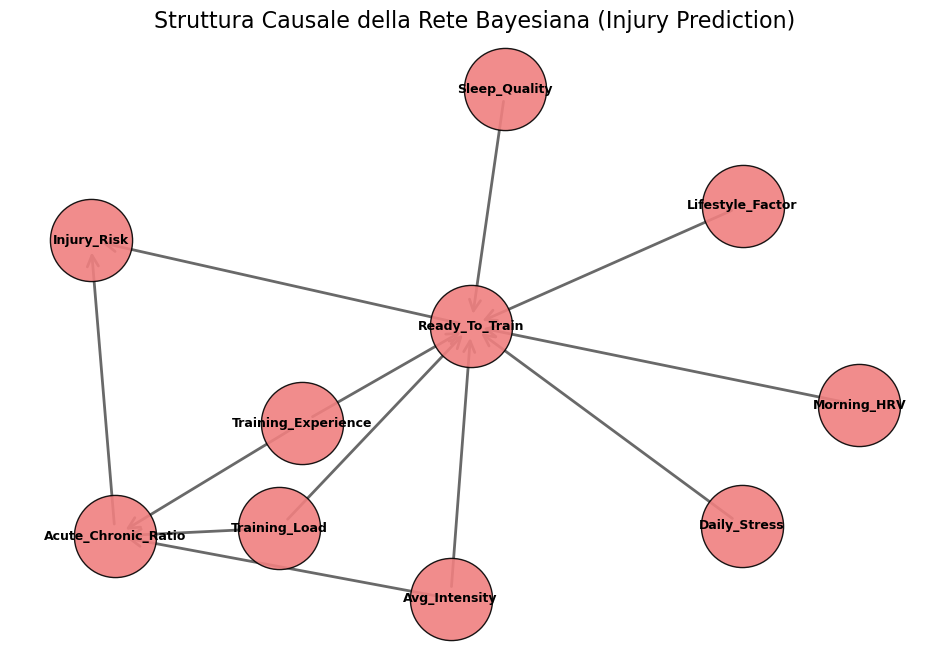


--- Struttura testuale (Archi) ---
[('Training_Experience', 'Ready_To_Train'), ('Training_Experience', 'Acute_Chronic_Ratio'), ('Ready_To_Train', 'Injury_Risk'), ('Acute_Chronic_Ratio', 'Injury_Risk'), ('Lifestyle_Factor', 'Ready_To_Train'), ('Sleep_Quality', 'Ready_To_Train'), ('Morning_HRV', 'Ready_To_Train'), ('Daily_Stress', 'Ready_To_Train'), ('Training_Load', 'Acute_Chronic_Ratio'), ('Training_Load', 'Ready_To_Train'), ('Avg_Intensity', 'Acute_Chronic_Ratio'), ('Avg_Intensity', 'Ready_To_Train')]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork

# 1. Ridefinisci la struttura (come nel codice corretto precedente)
BN_STRUCTURE = [
    ('Training_Experience', 'Ready_To_Train'),
    ('Training_Experience', 'Acute_Chronic_Ratio'),
    ('Lifestyle_Factor', 'Ready_To_Train'),
    ('Sleep_Quality', 'Ready_To_Train'),
    ('Morning_HRV', 'Ready_To_Train'),
    ('Daily_Stress', 'Ready_To_Train'),
    ('Training_Load', 'Acute_Chronic_Ratio'),
    ('Training_Load', 'Ready_To_Train'),
    ('Avg_Intensity', 'Acute_Chronic_Ratio'),
    ('Avg_Intensity', 'Ready_To_Train'),
    ('Ready_To_Train', 'Injury_Risk'),
    ('Acute_Chronic_Ratio', 'Injury_Risk'),
]

# 2. Crea il modello pgmpy
injury_risk_model = DiscreteBayesianNetwork(BN_STRUCTURE)

# 3. CONVERSIONE E VISUALIZZAZIONE
print("Generazione del grafo...")

# Converte il modello pgmpy in un oggetto Grafo di networkx
graph = nx.DiGraph(injury_risk_model.edges())

# Imposta il layout (es. kamada_kawai_layout per un layout spaziale più organico)
# o shell_layout, circular_layout, spring_layout, ecc.
pos = nx.spring_layout(graph, seed=42, k=0.5) 

plt.figure(figsize=(12, 8))
plt.title("Struttura Causale della Rete Bayesiana (Injury Prediction)", fontsize=16)

# Disegna i nodi e gli archi
nx.draw_networkx_nodes(
    graph, pos, 
    node_size=3500, 
    node_color='blue', 
    edgecolors='black', 
    alpha=0.9
)

# Disegna le etichette dei nodi
nx.draw_networkx_labels(
    graph, pos, 
    font_size=9, 
    font_weight='bold', 
    font_color='black'
)

# Disegna gli archi
nx.draw_networkx_edges(
    graph, pos, 
    arrowstyle='->', 
    arrowsize=20, 
    edge_color='dimgray', 
    width=2
)

plt.axis('off') # Rimuove gli assi di matplotlib
plt.show()

# Stampa la struttura testuale (per completezza)
print("\n--- Struttura testuale (Archi) ---")
print(injury_risk_model.edges)